# Problem with p_ij growing faster than p_i * p_j 
This notebook is just to state this problem clearly and to document how far I got into locating its source and solving it

In [1]:
from __future__ import print_function
import pprint
import subprocess
import sys 
sys.path.append('../')

import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns

from network import BCPNN, NetworkManager, BCPNNFast, Protocol
from data_transformer import build_ortogonal_patterns
from plotting_functions import plot_state_variables_vs_time, plot_network_activity, plot_network_activity_angle
from plotting_functions import  plot_adaptation_dynamics, plot_weight_matrix, plot_winning_pattern, plot_sequence

%matplotlib inline
matplotlib.rcParams.update({'font.size': 22})

np.set_printoptions(suppress=True, precision=2)

sns.set(font_scale=2.0)

#### Git Machinery

In [2]:
run_old_version = False
if run_old_version:
    hash_when_file_was_written = '5381c361c1b331e06c111138834676fa0085faaa'
    hash_at_the_moment = subprocess.check_output(["git", 'rev-parse', 'HEAD']).strip()
    print('Actual hash', hash_at_the_moment)
    print('Hash of the commit used to run the simulation', hash_when_file_was_written)
    subprocess.call(['git', 'checkout', hash_when_file_was_written])

First we build the network, manager and protocol. 

In [3]:

# Patterns parameters
hypercolumns = 4
minicolumns = 10
n_patterns = 5  # Number of patterns

# Manager properties
dt = 0.001
T_recalling = 0.5
values_to_save = ['o', 's', 'z_pre', 'z_post', 'p_pre', 'p_post', 'p_co', 'z_co', 'w']

# Protocol
training_time = 0.1
inter_sequence_interval = 0.0
inter_pulse_interval = 0.0
epochs = 1

# To experiment
# training_time = 0.5
# epochs = 10

# Build patterns
patterns_dic = build_ortogonal_patterns(hypercolumns, minicolumns)
patterns = list(patterns_dic.values())
patterns = patterns[:n_patterns]

# Build the network
nn = BCPNNFast(hypercolumns, minicolumns)
nn.tau_a = 0.150
nn.sigma = 0
nn.k_inner = True
nn.tau_k = 0.300

# Build the manager
manager = NetworkManager(nn=nn, dt=dt, values_to_save=values_to_save)

# Build the protocol for training
protocol = Protocol()
protocol.simple_protocol(patterns, training_time=training_time, inter_pulse_interval=inter_pulse_interval,
                         inter_sequence_interval=inter_sequence_interval, epochs=epochs)

Run the network

In [4]:
epoch_history = manager.run_network_protocol(protocol=protocol, verbose=False, values_to_save_epoch=['w'])

Graphs

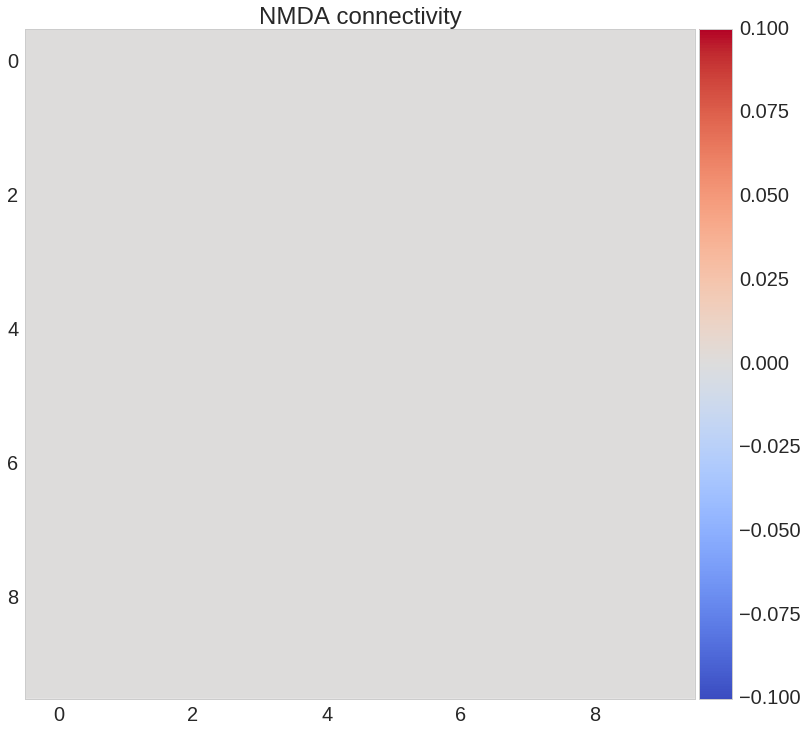

In [5]:
plot_weight_matrix(nn, one_hypercolum=True)

We can appreciate in this graph most of our problems:
* The strong connections among free atractor (red part) even if k.inner is True. 
* The connections from the the free atractor to the sequence that we store (top right rows).
* The connection from the first member of the sequence (0) to the free atractor (first column, bottom)

I think right now that all those problems steem from the fact that $p_{ij}$ grows faster than $p_i * p_j$ just at the beggining of the simulation. The mechanism is the following.


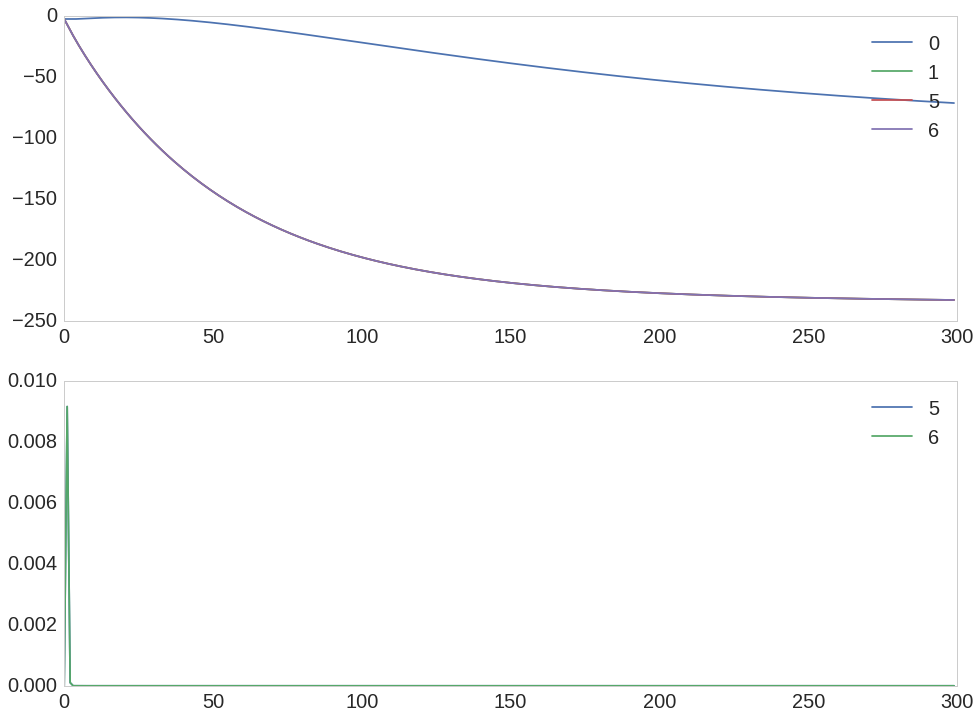

In [6]:
s = manager.history['s'][:, :manager.nn.minicolumns]
o = manager.history['o'][:, :manager.nn.minicolumns]
traces_to_plot1 = [0, 1, 5, 6]
traces_to_plot2 = [5, 6]

fig = plt.figure(figsize=(16, 12))
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)

for trace in traces_to_plot1:
    ax1.plot(s[:300, trace], label=str(trace))

for trace in traces_to_plot2:
    ax2.plot(o[:300, trace], label=str(trace))
    
ax1.legend()
ax2.legend()

The normalization of o, creates a small perturbation in the o's that are not participating in the beggining. Those get followed by their respectives z-traces and p-traces as we show next:

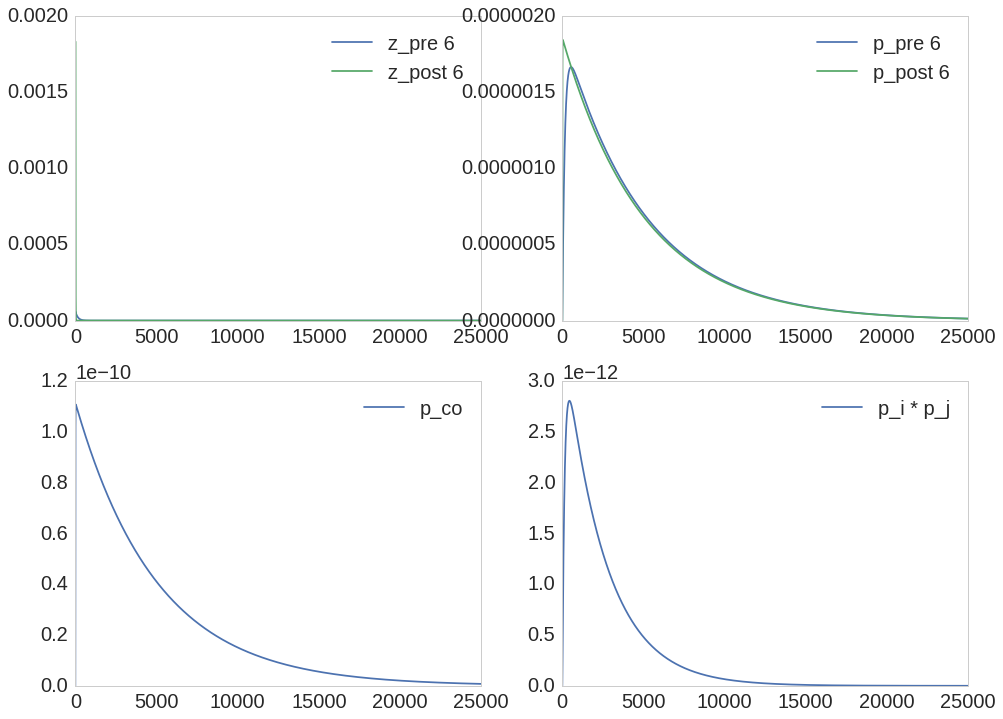

In [7]:
trace = 6
N = int(training_time * n_patterns * epochs / dt) - 10

z_pre = manager.history['z_pre'][:N, trace]
z_post = manager.history['z_post'][:N, trace]

p_pre = manager.history['p_pre'][:N, trace]
p_post = manager.history['p_post'][:N, trace]

p_co = manager.history['p_co'][:N, trace, 6]

fig = plt.figure(figsize=(16, 12))
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)

ax1.plot(z_pre, label='z_pre ' + str(trace))
ax1.plot(z_post, label='z_post ' + str(trace))
ax1.legend()

ax2.plot(p_pre, label='p_pre ' + str(trace))
ax2.plot(p_post, label='p_post ' + str(trace))
ax2.legend()

ax3.plot(p_co, label='p_co')
ax3.legend()

ax4.plot(p_pre * p_post, label='p_i * p_j')
ax4.legend();

Things to observe form this graph:
* The z's decay according to their traces, z_post decays faster than z_pre because its $\tau$ is smaller. 
* p's are actually following the values of z, p_pre satures at a higher value because z_pre has a higher value and this follows. Also
* The mechanism involving in the grow of p involved the time constants of z, due to this we can appreciate that p_post grows faster. 
* Finally $p_i * p_j$ is far smaller than $p_{ij}$ which explains the spikes of positive values of $w_{ij}$

We can see the spike of the values of $w_{ij}$ in the following graph. 

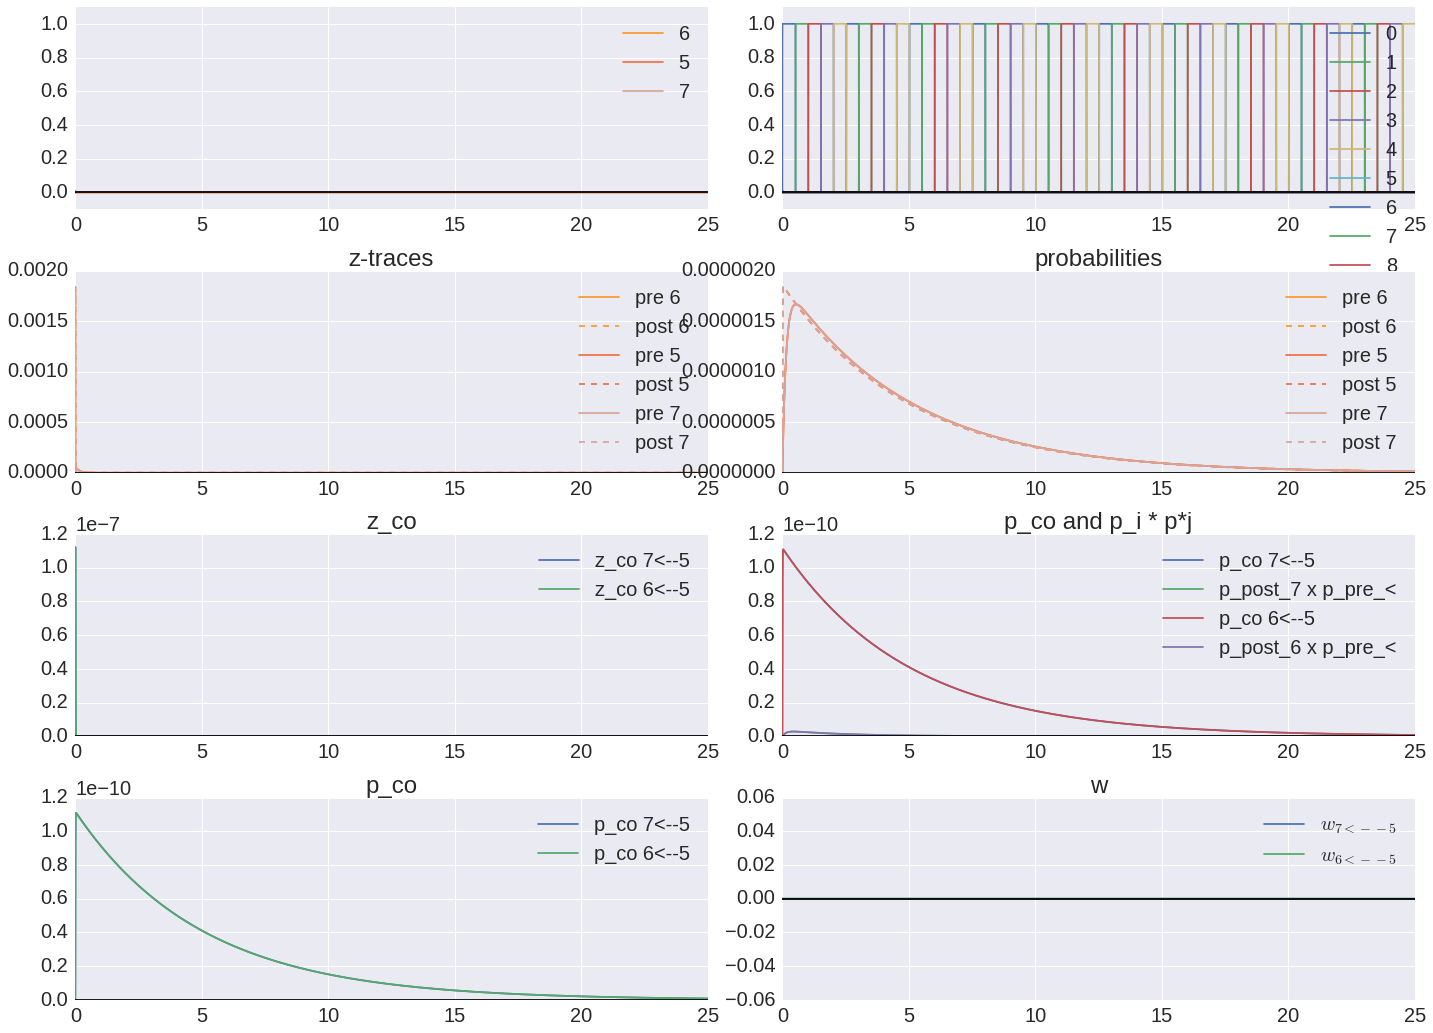

In [8]:
traces_to_plot = [6, 5, 7]
plot_state_variables_vs_time(manager, traces_to_plot, ampa=False)

This initial spike is reponsible for the connections between 0 and 6, 7 (the free atractor). Because both of them are activated at the beggining and because of the slow decay of the p-traces this remains like that. 

#### 0 to free attractor

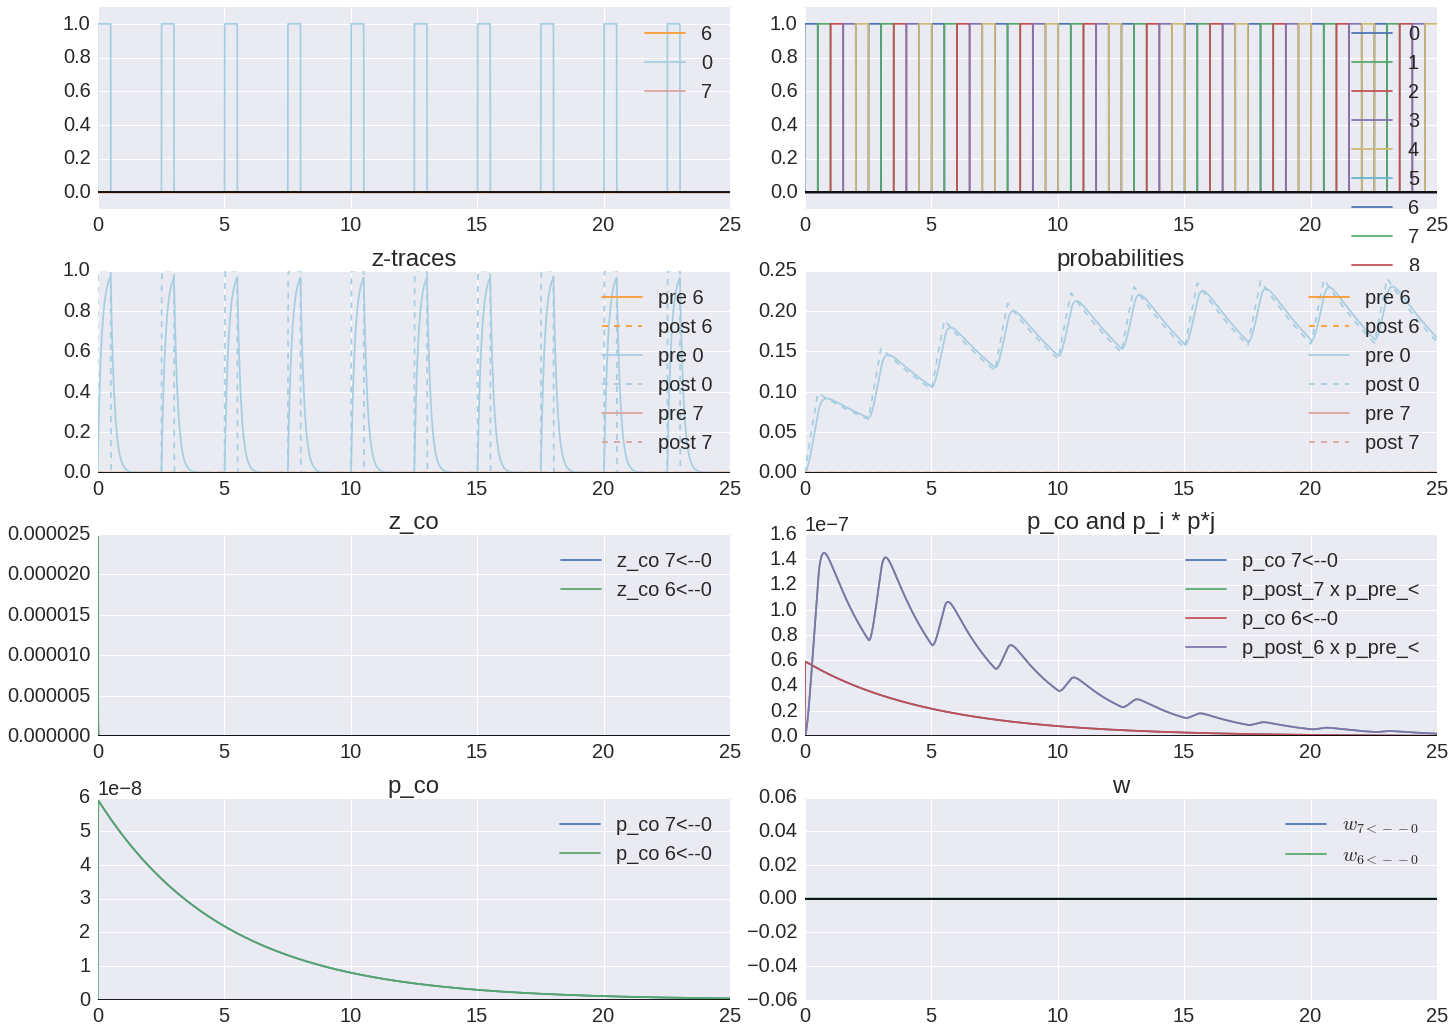

In [9]:
traces_to_plot = [6, 0, 7]
plot_state_variables_vs_time(manager, traces_to_plot, ampa=False)

The same mechanism can be used to explain the connections from the free attractor to the 0 trace. The spike at p_ij at the beggining that is preserved because of the slow decay of p

#### Free attractor to first elements of the sequence

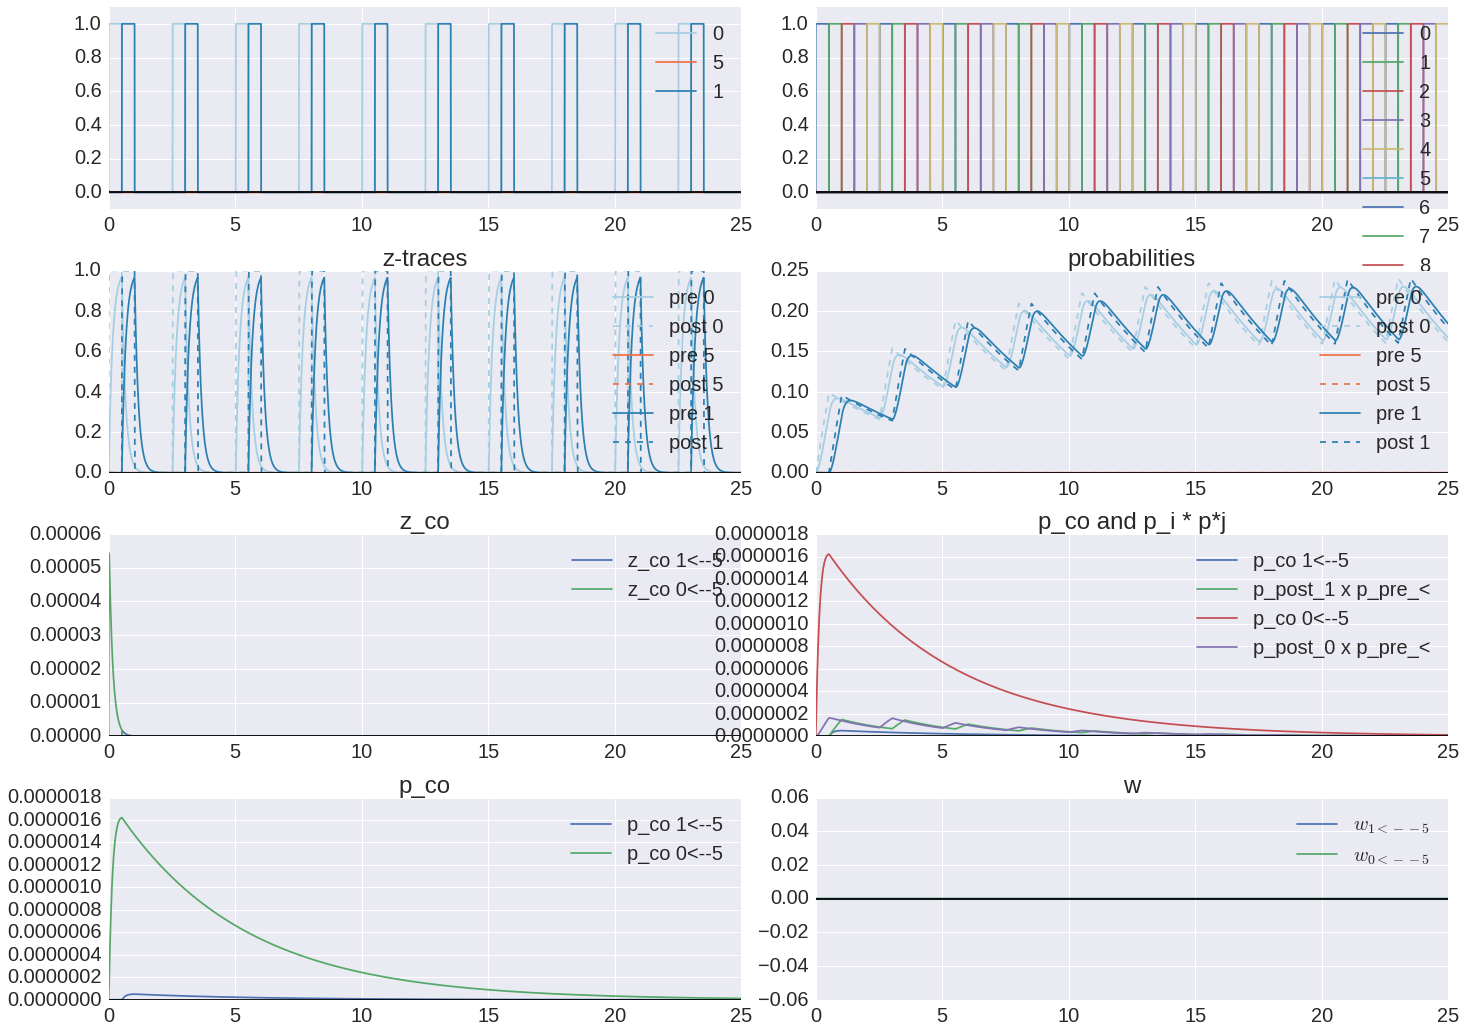

In [10]:
traces_to_plot = [0, 5, 1]
plot_state_variables_vs_time(manager, traces_to_plot, ampa=False)

Finally this casts doubt over normal connectivity values in our proper sequence, because of the initial spike

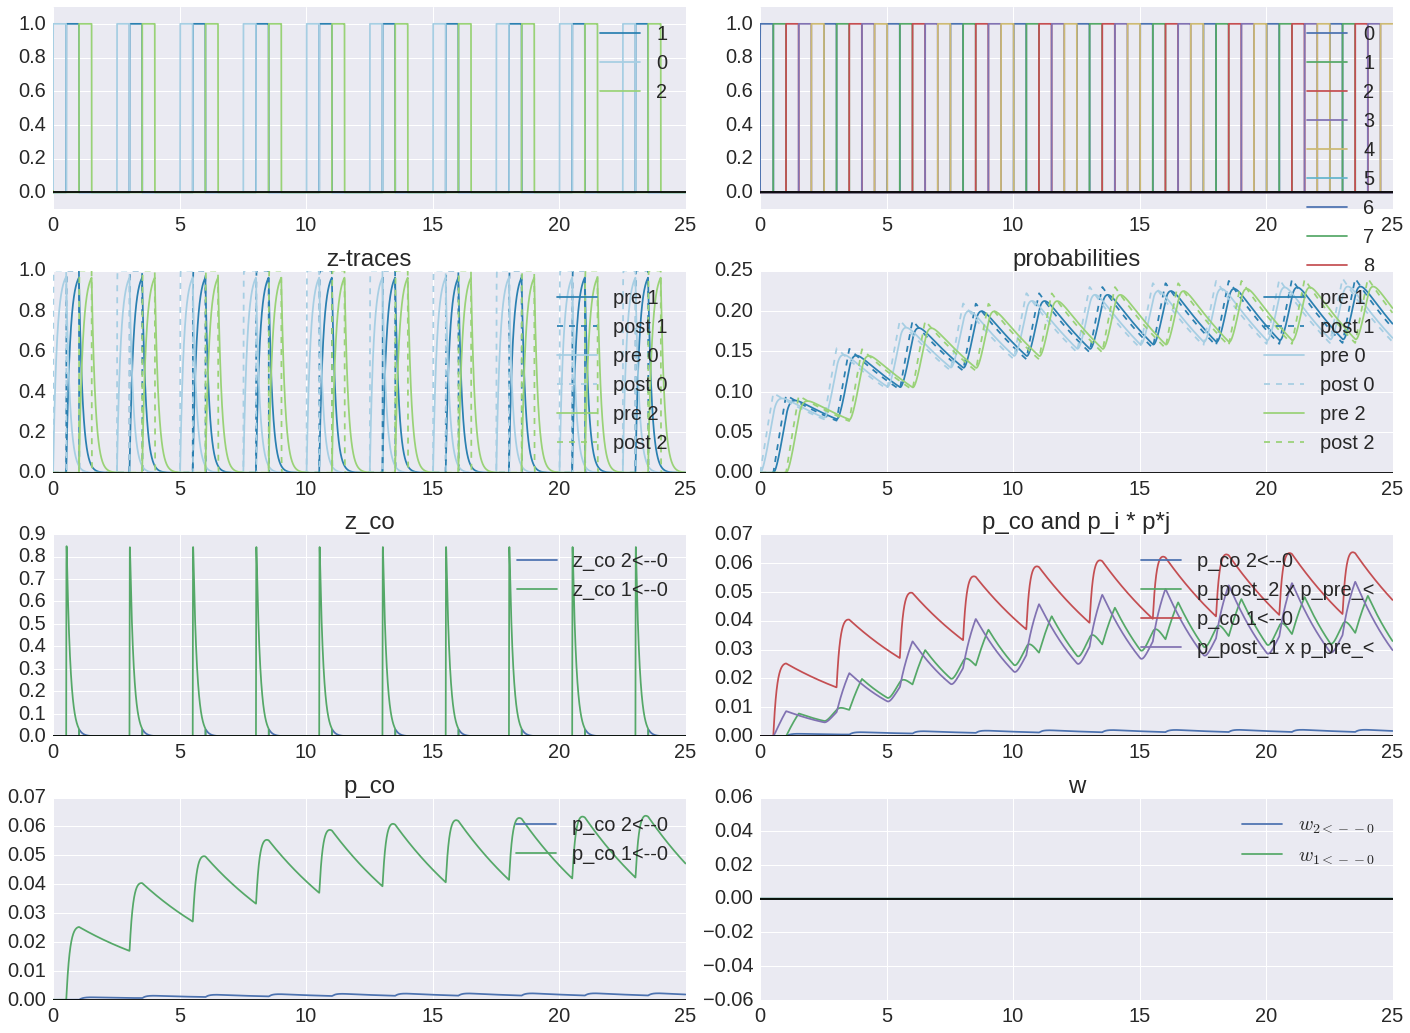

In [11]:
traces_to_plot = [1, 0, 2]
plot_state_variables_vs_time(manager, traces_to_plot, ampa=False)